## Introduction

(From [adapter-transformers doc page](https://docs.adapterhub.ml/overview.html))

Large pre-trained Transformer-based language models (LMs) have become the foundation of NLP in recent years. While the most prevalent method of using these LMs for transfer learning involves costly full fine-tuning of all model parameters, a series of efficient and lightweight alternatives have recently been established. Instead of updating all parameters of the pre-trained LM towards a downstream target task, these methods commonly introduce a small number of new parameters and only update these while keeping the pre-trained model weights fixed.

> Why use Parameter Efficient Fine-Tuning?</br>
  Parameter Efficient fine-tuning methods offer multiple benefits over the full fine-tuning of LMs:</br>They are parameter-efficient, i.e., they only update a tiny subset (often under 1%) of a model’s parameters.</br>They often are modular, i.e., the updated parameters can be extracted and shared independently of the base model parameters.</br>They are easy to share and deploy due to their small file sizes, e.g., having only ~3MB per task instead of ~440MB for sharing a full model.</br>They speed up training, i.e., parameter efficient fine-tuning often requires less training time than fully fine-tuning LMs.</br>They are composable, e.g., multiple adapters trained on different tasks can be stacked, fused, or mixed to leverage their combined knowledge.</br>They often provide on-par performance with full fine-tuning.

More specifically, let the parameters of a LM be composed of a set of pre-trained parameters Θ
 (frozen) and a set of (newly introduced) parameters Φ
. Then, efficient fine-tuning methods optimize only Φ
 according to a loss function L
 on a dataset D
:

<center>$Φ^∗←{argmin}_{Φ}L(D;\{Θ,Φ\})$</center>

</br>Efficient fine-tuning might insert parameters $Φ$
 at different locations of a Transformer-based LM. One early and successful method, (bottleneck) adapters, introduces bottleneck feed-forward layers in each layer of a Transformer model. While these adapters have laid the foundation of the adapter-transformers library, multiple alternative methods have been introduced and integrated since.

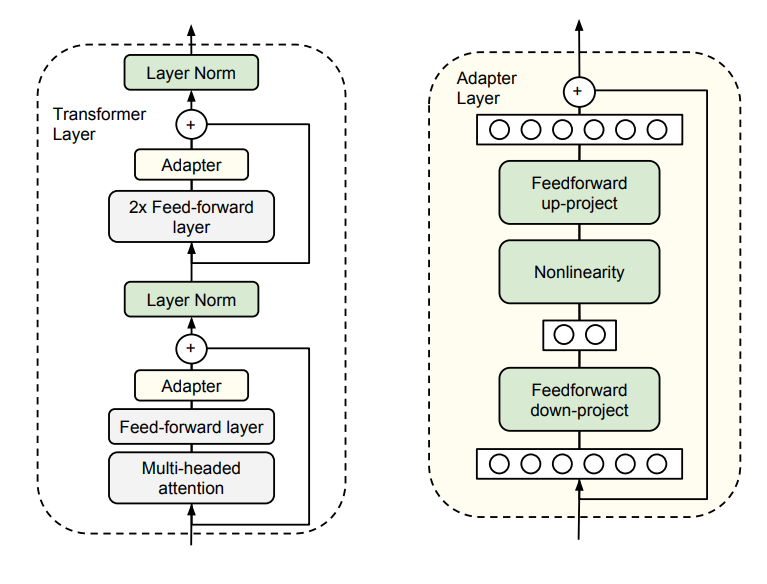

### Requirements

In [1]:
%%capture
! pip install datasets transformers

### Imports

In [2]:
from tqdm.notebook import tqdm
from IPython import display

import numpy as np
import pandas as pd
import math

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn

from datasets import load_dataset
from transformers import T5TokenizerFast, T5ForConditionalGeneration, DataCollatorForSeq2Seq
from transformers.models.t5.modeling_t5 import T5LayerFF

### Constants

We will use `t5-small` as our base model from Hugging Face ([HF_Link](https://huggingface.co/t5-small)). And we use `32` as our adapter bottleneck size.

In [3]:
#####################################
###### DO NOT CHANGE THIS CELL ######
#####################################

BASE_MODEL_NAME = 't5-small'

BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 10
BOTTLENECK_SIZE = 8

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset

### Load dataset

`imdb` dataset is a famouns NLP sentiment dataset. Each row of data is either `negative` or `positive`.

In [4]:
dataset = load_dataset('imdb')
dataset.pop('unsupervised')
print(dataset)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})


### Define related functions

Because `T5` model is a sequence to sequence model we should map our labels to label_names before training and doing vice versa duing calculating metrics.

The functions `id2label` and `label2id` are defined to do this.

In [5]:
def id2label(ids):
    label_names = ['negative', 'positive']
    return [label_names[id] for id in ids]

def label2id(labels):
    label_names_dict = {
        'negative': 0,
        'positive': 1
    }
    return [
        label_names_dict.get(label, 2)
        for label in labels
    ]

# Tokenizer

### Load tokenizer

In [6]:
tokenizer = T5TokenizerFast.from_pretrained(BASE_MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

### Process dataset using tokenizer

In this step we will getting our dataset ready for training.

We preprocess tokenize our `text` and `label`.

In [7]:
def preprocess_input(text):
    text = text.lower()
    text = text.replace('<br />', ' ')
    return text

def map_function(row):
    processed_input = [
        preprocess_input(text)
        for text in row['text']
    ]
    input_info = tokenizer(processed_input, truncation=True, max_length=256)
    output_info = tokenizer(id2label(row['label']))
    return {
        **input_info,
        'labels': output_info.input_ids
    }


dataset = dataset.map(map_function, batched=True)
dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

# Model

### Load model

In [8]:
model = T5ForConditionalGeneration.from_pretrained(BASE_MODEL_NAME)

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

## Implementing Adapter

In [9]:
class AdapterLayer(nn.Module):
    def __init__(
        self,
        emb_dim: int,
        bottleneck_size: int
    ):

        super().__init__()

        ######### Your code begins #########
        self.sharif_llm_adapter = nn.Sequential(
            nn.Linear(emb_dim, bottleneck_size),  # down-project
            nn.ReLU(),
            nn.Linear(bottleneck_size, emb_dim)   # up-project
        )
        ######### Your code ends ###########

    def forward(self, x: torch.Tensor):
        # do not remember to have residual connect
        ######### Your code begins #########
        output = x + self.sharif_llm_adapter(x)
        ######### Your code ends ###########

        return output

class FeedForwardAdapterWrapper(nn.Module):
    def __init__(
        self,
        original_module: T5LayerFF,
        bottleneck_size: int
    ):

        super().__init__()

        assert isinstance(original_module, T5LayerFF)

        self.original_module = original_module

        emb_dim = original_module.DenseReluDense.wi.in_features

        self.adapter = AdapterLayer(emb_dim, bottleneck_size)

    def forward(self, x: torch.Tensor):
        output = self.original_module(x)
        output = self.adapter(output)
        return output

### Change the model

In [10]:
def mutate_model_recursive(model: nn.Module, bottleneck_size: int):
    for name, module in model.named_children():
        if isinstance(module, T5LayerFF):
            ######### Your code begins #########
            feed_forward_with_adapter = FeedForwardAdapterWrapper(module, bottleneck_size)
            ######### Your code ends ###########
            setattr(model, name, feed_forward_with_adapter)
            print(f"Replaced {name} with FeedForwardAdapterWrapper layer.")
        else:
            mutate_model_recursive(module, bottleneck_size) # recursively call the function on the module

def mutate_model(model: nn.Module, bottleneck_size: int):
    if hasattr(model, '_mutated'):
        print("Model already contains adapter layers! \n Try reloading the model.")
        return

    # we want to add adapter after each T5LinearLayer
    # and iterate over the children of the model
    mutate_model_recursive(model, bottleneck_size)

    model._mutated = True


mutate_model(model, bottleneck_size=BOTTLENECK_SIZE)

Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 1 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.
Replaced 2 with FeedForwardAdapterWrapper layer.


### Freeze non Adapter params

In [11]:
def freeze_non_adapter(model, peft_key):
    print('Non freezed weights:')
    for param_name, weights in model.named_parameters():
        weights.requires_grad = peft_key in param_name
        if weights.requires_grad:
            print(param_name)

freeze_non_adapter(model, peft_key='sharif_llm')

Non freezed weights:
encoder.block.0.layer.1.adapter.sharif_llm_adapter.0.weight
encoder.block.0.layer.1.adapter.sharif_llm_adapter.0.bias
encoder.block.0.layer.1.adapter.sharif_llm_adapter.2.weight
encoder.block.0.layer.1.adapter.sharif_llm_adapter.2.bias
encoder.block.1.layer.1.adapter.sharif_llm_adapter.0.weight
encoder.block.1.layer.1.adapter.sharif_llm_adapter.0.bias
encoder.block.1.layer.1.adapter.sharif_llm_adapter.2.weight
encoder.block.1.layer.1.adapter.sharif_llm_adapter.2.bias
encoder.block.2.layer.1.adapter.sharif_llm_adapter.0.weight
encoder.block.2.layer.1.adapter.sharif_llm_adapter.0.bias
encoder.block.2.layer.1.adapter.sharif_llm_adapter.2.weight
encoder.block.2.layer.1.adapter.sharif_llm_adapter.2.bias
encoder.block.3.layer.1.adapter.sharif_llm_adapter.0.weight
encoder.block.3.layer.1.adapter.sharif_llm_adapter.0.bias
encoder.block.3.layer.1.adapter.sharif_llm_adapter.2.weight
encoder.block.3.layer.1.adapter.sharif_llm_adapter.2.bias
encoder.block.4.layer.1.adapter.sha

# Train and evaluate

### Define dataloaders

In [12]:
col_fn = DataCollatorForSeq2Seq(
    tokenizer, return_tensors='pt', padding='longest',
)

train_loader = torch.utils.data.DataLoader(
    dataset['train'],
    batch_size=BATCH_SIZE,
    collate_fn=col_fn,
    shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    dataset['test'],
    batch_size=BATCH_SIZE,
    collate_fn=col_fn
)

### Train functions

In [13]:
def train_loop(model, loader, optimizer):
    model.train()

    batch_losses = []

    for row in tqdm(loader, desc='Training:'):
        optimizer.zero_grad()

        out = model(**row.to(model.device))
        loss = out.loss

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)

    loss_value = np.mean(batch_losses)
    return {'train_loss': loss_value}

def _predict(model, row):
    return model.generate(
        input_ids=row.input_ids,
        attention_mask=row.attention_mask,
        max_length=5
    )

def tokenizer_ids_to_label(all_input_ids):
    return tokenizer.batch_decode(all_input_ids, skip_special_tokens=True)

def valid_loop(model, loader, compute_metrics):
    model.eval()

    all_true = []
    all_pred = []

    with torch.no_grad():
        for row in tqdm(loader, desc='Validating:'):
            row.to(model.device)
            pred = _predict(model, row)

            all_true += row.labels.detach().cpu().tolist()
            all_pred += pred.detach().cpu().tolist()

    all_true = label2id(tokenizer_ids_to_label(all_true))
    all_pred = label2id(tokenizer_ids_to_label(all_pred))

    return {'valid_acc': compute_metrics(y_true=all_true, y_pred=all_pred)}

### Define our optimizer and metric function

In [15]:
#optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
optimizer = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=LEARNING_RATE
)

compute_metrics = accuracy_score

In [16]:
model.to(DEVICE)

all_results = []
for epoch in range(EPOCHS):
    epoch_results = {'epoch': epoch}

    epoch_results.update(
        train_loop(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
        )
    )

    epoch_results.update(
        valid_loop(
            model=model,
            loader=test_loader,
            compute_metrics=compute_metrics,
        )
    )
    all_results.append(epoch_results)

    display.clear_output()
    display.display(pd.DataFrame(all_results).set_index('epoch'))

,train_loss,valid_acc
epoch,,
0,0.240646,0.87864
1,0.146973,0.89708
2,0.135014,0.90112
3,0.128283,0.89628
4,0.123592,0.89816
5,0.116720,0.90564
6,0.111812,0.90084
7,0.107742,0.90476
8,0.105422,0.90572


from matplotlib import pyplot as plt
_df_0['epoch'].plot(kind='hist', bins=20, title='epoch')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['train_loss'].plot(kind='hist', bins=20, title='train_loss')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['valid_acc'].plot(kind='hist', bins=20, title='valid_acc')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='epoch', y='train_loss', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='train_loss', y='valid_acc', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['train_loss']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_5.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('train_loss')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['epoch']
  ys = series['valid_acc']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_6.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('valid_acc')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['epoch']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'epoch'}, axis=1)
              .sort_values('epoch', ascending=True))
  xs = counted['epoch']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_7.sort_values('epoch', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('epoch')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_8['epoch'].plot(kind='line', figsize=(8, 4), title='epoch')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_9['train_loss'].plot(kind='line', figsize=(8, 4), title='train_loss')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_10['valid_acc'].plot(kind='line', figsize=(8, 4), title='valid_acc')
plt.gca().spines[['top', 'right']].set_visible(False)

### Best Performance and number of parameters

You must report this number in you final report.

In [17]:
best_score = pd.DataFrame(all_results)['valid_acc'].max() * 100
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")
print('Best model preformance is: %%%.1f' % best_score)

Number of parameters: 60611168
Best model preformance is: %90.6


In [19]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters (soft prompts only): {trainable_params}")


Number of trainable parameters (soft prompts only): 104544
